In [1]:
import numpy as np
from scipy.interpolate import interp1d
from diffusionpy import vpure,Diffusion_MS
import matplotlib.pyplot as plt

The experimental data was taken from https://doi.org/10.3390/pharmaceutics15051539

In [2]:
texp=np.asarray([15,30,45,60,90,120])


texp0=np.asarray([3.085106383,5.957446809,8.936170213,11.91489362,14.89361702,18.08510638,20.95744681,24.14893617,27.12765957,30,32.9787234,35.85106383,38.82978723,41.91489362,44.78723404,47.9787234,51.06382979,53.82978723,56.70212766,59.78723404])

relpoly00=np.asarray([0,0.037777778,0.095555556,0.157777778,0.211111111,0.268888889,0.324444444,0.364444444,0.408888889,0.457777778,0.495555556,0.533333333,0.564444444,0.591111111,0.615555556,0.651111111,0.673333333,0.702222222,0.722222222,0.755555556])*100

## Dl10
relapi10=np.asarray([10.50583658,19.84435798,28.40466926,38.13229572,52.14007782,62.25680934])
relpoly10=np.asarray([8.62745098,19.21568627,28.62745098,36.8627451,49.01960784,60.78431373])

## Dl20
relapi20=np.asarray([5.836575875,6.614785992,13.61867704,19.06614786,27.62645914,36.96498054])
relpoly20=np.asarray([5.098039216,8.235294118,16.07843137,22.74509804,32.94117647,42.74509804])

## Dl30
relapi30=np.asarray([1.945525292,1.945525292,3.112840467,3.891050584,5.447470817,7.003891051])
relpoly30=np.asarray([1.176470588,1.568627451,3.529411765,5.882352941,6.274509804,9.019607843]) 


In [3]:
T=310.15
p=1E5
par={"mi":np.asarray([1.20469,2420.99, 8.105152]),
"si": np.asarray([2.797059952,2.947, 2.939]),
"ui" :np.asarray([353.95,205.27, 229.45]),
"eAi" :np.asarray([2425.67,0., 934.2]),
"kAi":np.asarray([0.04509,0.02, 0.02]),
"NAi":np.asarray([1.,653., 2.]),
"Mi": np.asarray([18.015,65000.,230.26]),
"kij":np.asarray([-0.128,0.00648,-0.0574]),
"kijA":np.asarray([0.,0.,0.]),
"deltaHSL":np.asarray([0.,0.,31500.]),
'TSL':np.asarray([0.,0.,429.47]),
"cpSL":np.asarray([0.,0.,87.44])}
vpures=vpure(p,T,**par)
par["vpure"]=vpures

In [4]:
nt=101
t=np.linspace(0,texp[-1],nt)*60
mobile=np.asarray([True,True,True])
# crystpar={"A":1e-10,"B":4.15E7 ,"n":1}


# this dictionary stores the parameters for the nucleation-crystallization model
crystpar={"A":4E-11, #kinetic parameter for the crystallization kinetics 
"B":4.15E7 , #  nucleation barrier parameter
"n":2}

Dvec00=np.asarray([1E-9,1E-9,1E-9])
Dvec10=np.asarray([1E-9,1E-9,1E-9])
Dvec20=np.asarray([1E-10,1E-10,1E-10])
Dvec30=np.asarray([2E-10/32,2E-10/32,2E-10/32])

L00=5E-3
L10=10.4E-3/2
L20=5.2E-3/2
L30=3.5E-3/2


def release_calc(wi0,wi8,Dvec,L):
       wt,wtz,zvec,Lt,alpha=Diffusion_MS(t,L,Dvec,wi0,wi8,mobile,T=T,p=p,saftpar=par,maxiter=None,**crystpar)
       notreleased=wt/wi0
       release=(1-notreleased)
       return release,alpha,wtz,zvec

dl000=0.
dl010=0.1
dl020=0.2
dl030=0.3
nc=3
wv0=0.01
wv8=0.999

def limits(dl0,wv0,wv8):
       wi0=np.asarray([wv0,(1-wv0)*(1-dl0),(1-wv0)*dl0])
       wi8=np.asarray([wv8,(1-wv8)*(1-dl0),(1-wv8)*dl0])
       return wi0,wi8
       
wi000,wi800=limits(dl000,wv0,wv8)
wi010,wi810=limits(dl010,wv0,wv8)
wi020,wi820=limits(dl020,wv0,wv8)
wi030,wi830=limits(dl030,wv0,wv8)


wt00,wtz00,_,_=Diffusion_MS(t,L00,Dvec00,wi000,wi800,mobile,full_output=True)
notreleased00=wt00/wi000

release00=(1-notreleased00)
release10,alpha10,wtz10,zvec=release_calc(wi010,wi810,Dvec10,L10)
release20,alpha20,wtz20,_=release_calc(wi020,wi820,Dvec20,L20)
release30,alpha30,wtz30,_=release_calc(wi030,wi830,Dvec30,L30)
wasser10=wtz10[:,0,:]
wasser20=wtz20[:,0,:]
wasser30=wtz30[:,0,:]

(0.0, 130.0)

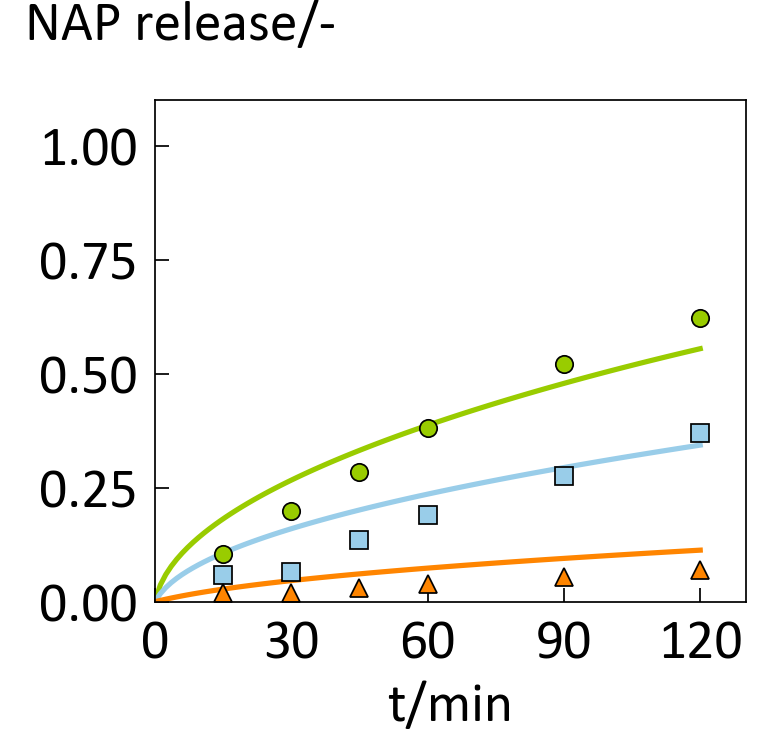

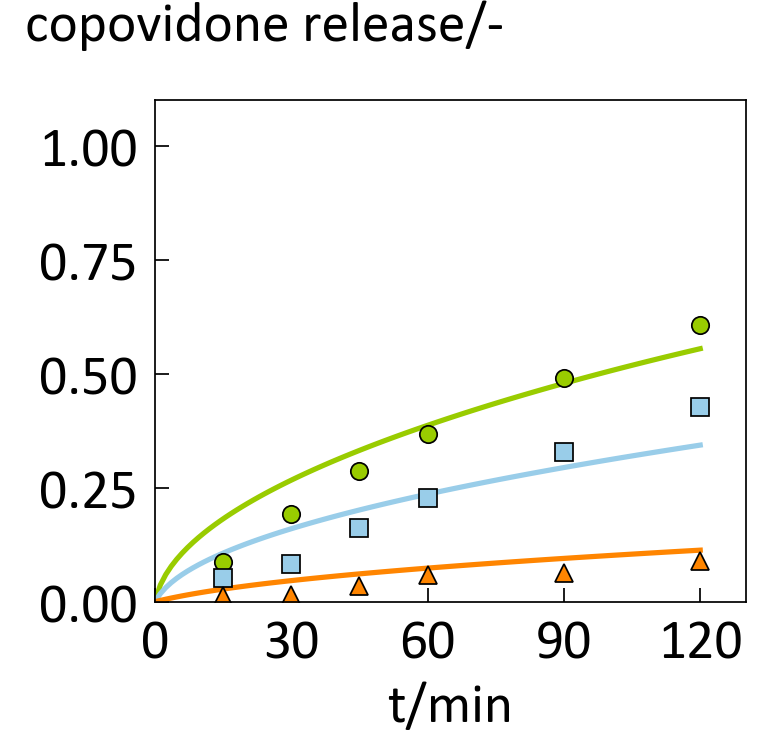

In [5]:
wt00,wtz00,_,_=Diffusion_MS(t,L00,Dvec00,wi000,wi800,mobile,full_output=True)
notreleased00=wt00/wi000
release00=(1-notreleased00)


fig,ax=plt.subplots()
ax.set_axisbelow(True)

ax.plot(t/60,release10[:,2],"C0-")
ax.plot(t/60,release20[:,2],"C1-")
ax.plot(t/60,release30[:,2],"C3-")

ax.plot(texp,relapi10/100,"C0o")
ax.plot(texp,relapi20/100,"C1s")
ax.plot(texp,relapi30/100,"C3^")


ax.set_xlabel("t/min")
ax.set_ylabel("NAP release/-",rotation=0,y=1.1,horizontalalignment='left')
ax.set_xticks([0.,30.,60.,90.,120.])
ax.set_yticks([0.,0.25,0.5,0.75,1.])
# ax.set_ticks(0,120,0,100)
plt.ylim(0,1.1)
plt.xlim(0,130)


fig5,ax5=plt.subplots()


# origin_like.plot(ax5,t/60,release00[:,1]*100,"g--")
ax5.plot(t/60,release10[:,1],"C0-")
ax5.plot(t/60,release20[:,1],"C1-")
ax5.plot(t/60,release30[:,1],"C3-")


# origin_like.plot(ax5,texp0,relpoly00,"gs")
ax5.plot(texp,relpoly10/100,"C0o")
ax5.plot(texp,relpoly20/100,"C1s")
ax5.plot(texp,relpoly30/100,"C3^")

ax5.set_xlabel("t/min")
ax5.set_ylabel("copovidone release/-",rotation=0,y=1.1,horizontalalignment='left')
ax5.set_xticks([0.,30.,60.,90.,120.])
ax5.set_yticks([0.,0.25,0.5,0.75,1.])
# origin_like.set_ticks(ax5,0,120,0,100)
plt.ylim(0,1.1)
plt.xlim(0,130)



Text(0.5, 0, 'depth /mm')

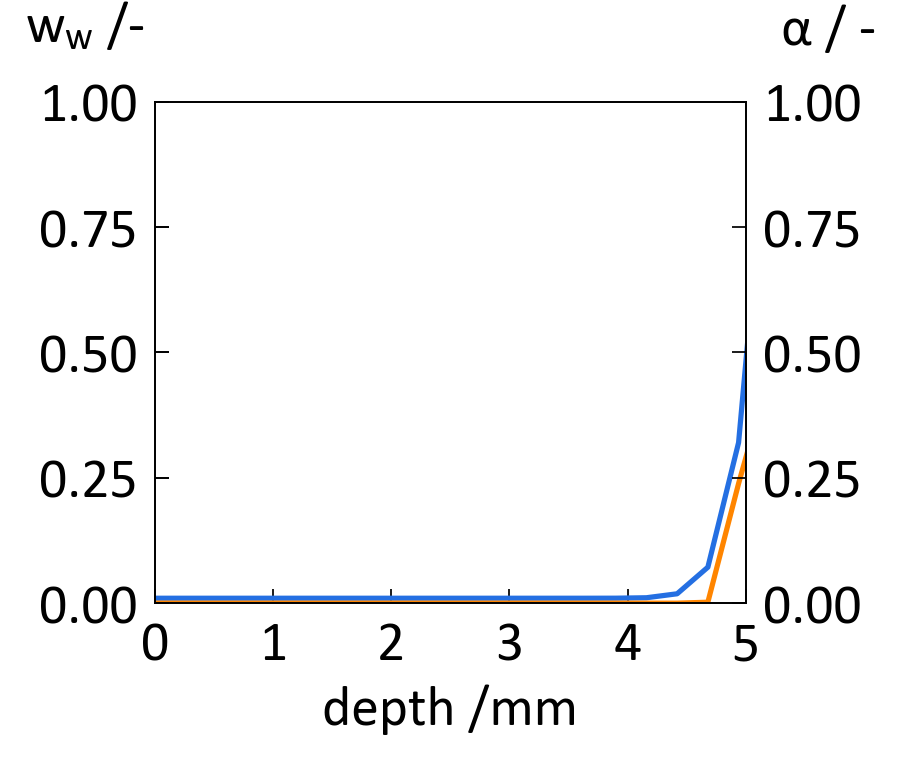

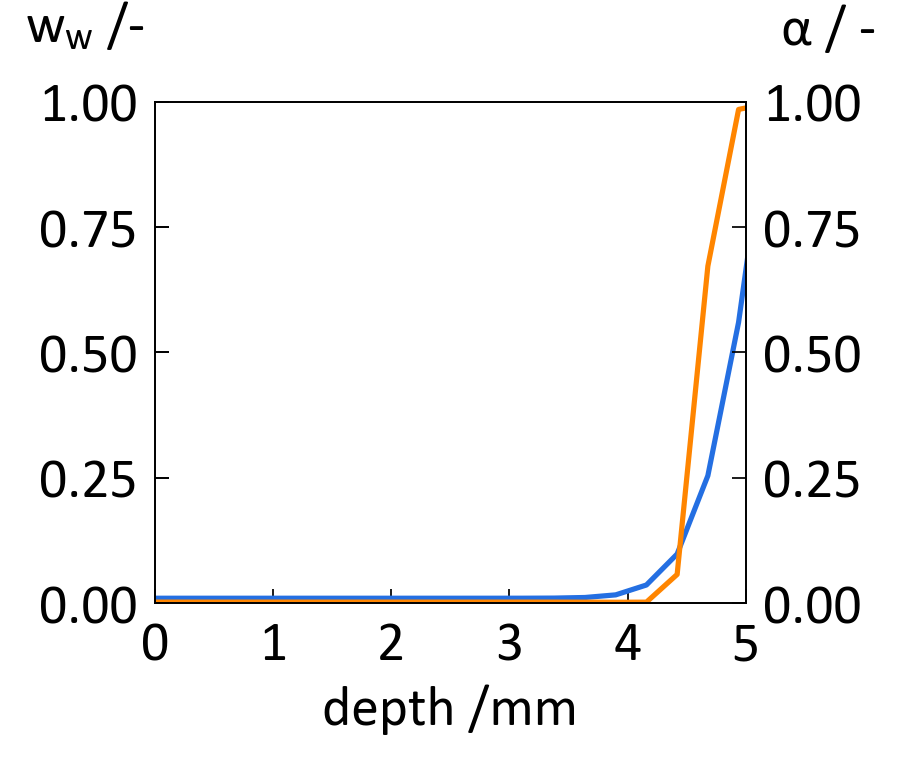

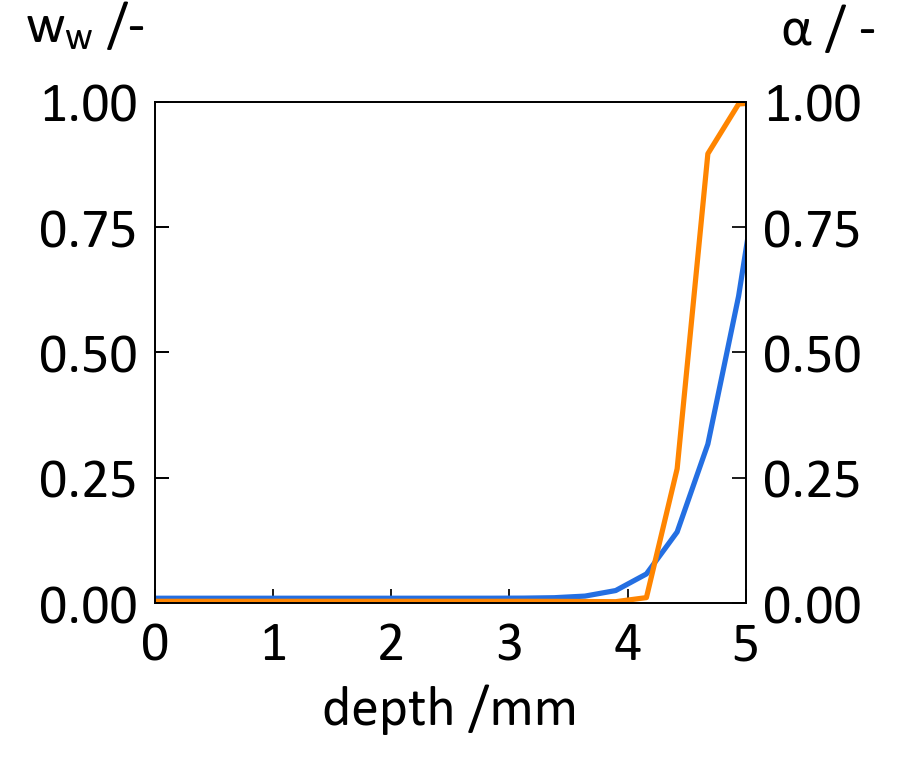

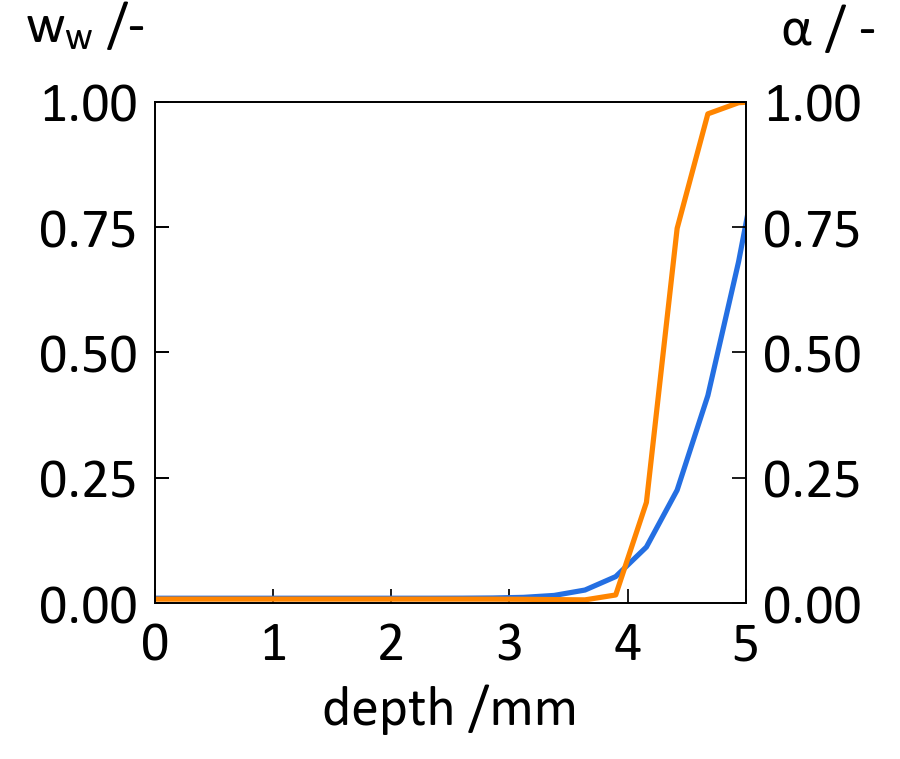

In [22]:

tp=nt

fig12,ax12=plt.subplots()
ax12.plot(zvec*1E3,wasser30[tp//12,:],"C2-")
ax12.plot(zvec*1E3,alpha30[:,tp//12],"C3-")
ax12.set_xticks([0,1,2,3,4,5])
ax12.set_yticks([0,0.25,0.5,0.75,1])
ax12.set_xlim(0,5)
ax12.set_ylim(0,1)
ax121 = ax12.twinx()
ax121.set_ylabel(r'$\alpha$ / -',rotation=0,y=1.2,horizontalalignment='right')
ax121.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True, direction="in",length=4, width=0.5)

fig13,ax13=plt.subplots()
ax13.plot(zvec*1E3,wasser30[tp//4,:],"C2-")
ax13.plot(zvec*1E3,alpha30[:,tp//4],"C3-")
ax13.set_xticks([0,1,2,3,4,5])
ax13.set_yticks([0,0.25,0.5,0.75,1])
ax13.set_xlim(0,5)
ax13.set_ylim(0,1)
ax131 = ax13.twinx()
ax131.set_ylabel(r'$\alpha$ / -',rotation=0,y=1.2,horizontalalignment='right')
ax131.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True, direction="in",length=4, width=0.5)


fig14,ax14=plt.subplots()
ax14.plot(zvec*1E3,wasser30[tp//3,:],"C2-")
ax14.plot(zvec*1E3,alpha30[:,tp//3],"C3-")
ax14.set_xticks([0,1,2,3,4,5])
ax14.set_yticks([0,0.25,0.5,0.75,1])
ax14.set_xlim(0,5)
ax14.set_ylim(0,1)
ax141 = ax14.twinx()
ax141.set_ylabel(r'$\alpha$ / -',rotation=0,y=1.2,horizontalalignment='right')
ax141.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True, direction="in",length=4, width=0.5)

fig15,ax15=plt.subplots()
ax15.plot(zvec*1E3,wasser30[tp//2,:],"C2-")
ax15.plot(zvec*1E3,alpha30[:,tp//2],"C3-")
ax15.set_xticks([0,1,2,3,4,5])
ax15.set_yticks([0,0.25,0.5,0.75,1])
ax15.set_xlim(0,5)
ax15.set_ylim(0,1)
ax151 = ax15.twinx()
ax151.set_ylabel(r'$\alpha$ / -',rotation=0,y=1.2,horizontalalignment='right')
ax151.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=True, bottom=True, top=True, left=True, right=True, direction="in",length=4, width=0.5)

ax12.set_ylabel("$w_w$ /-",rotation=0,y=1.1,horizontalalignment='left')
ax12.set_xlabel("depth /mm")
ax13.set_ylabel("$w_w$ /-",rotation=0,y=1.1,horizontalalignment='left')
ax13.set_xlabel("depth /mm")
ax14.set_ylabel("$w_w$ /-",rotation=0,y=1.1,horizontalalignment='left')
ax14.set_xlabel("depth /mm")
ax15.set_ylabel("$w_w$ /-",rotation=0,y=1.1,horizontalalignment='left')
ax15.set_xlabel("depth /mm")


